In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [2]:
def gen_data(n, mu, sigma, p):
    labels = torch.bernoulli(torch.Tensor(n, 1).fill_(p))
    clusterId = torch.bernoulli(torch.Tensor(n, 1).fill_(0.75)).long()
    ones = torch.normal(mu*(2*clusterId-1), sigma)
    zeros = torch.normal(-mu*(2*clusterId-1), sigma)
    data = torch.where(labels==1, ones, zeros)
    return data, labels

In [49]:
def resample(xs, ys, n):
    def sample(xs, n):
        # sample n points from xs with replacement
        idxs = torch.randint(0, len(xs), (n,))
        return xs[idxs]
    xNew = sample(xs[ys==1], n//2)
    xNew = torch.cat([xNew, sample(xs[ys==0], n//2)])
    return xNew.unsqueeze(1)

def reweight(model, xs):
    '''
    Reweights the data using the model and returns the reweighted data.
    '''
    outputs = model(xs)
    probsPred = torch.sigmoid(outputs)
    labelPreds = (probsPred > 0.5).float().detach()
    p = torch.mean(labelPreds)
    w = p / (1-p)
    return w

def adapt(model, xTarget, epochs = 10000, lr = 0.00002):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    models = [(copy.deepcopy(model), reweight(model, xTarget))]
    optimizer = torch.optim.Adam(model[0].parameters(), lr=lr)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model[0](xTarget)
        
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        xs = resample(xTarget, labelPreds, len(xTarget))

        optimizer.zero_grad()
        outputs = model(xs)
        
        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        
        loss = F.binary_cross_entropy(probsPred, labelPreds)
        loss.backward()    
        optimizer.step()
        
        if i % 100 == 0:
            models.append((copy.deepcopy(model), reweight(model, xTarget)))
    
    return models

In [23]:
def grad_by_data_on_model(model, xs):
    model.zero_grad()
    probPred = torch.sigmoid(model(xs))
    labelPred = (probPred > 0.5).float().detach()
    loss = F.binary_cross_entropy(probPred, labelPred)
    loss.backward()
    return model[0].weight.grad.data.clone(), model[0].bias.grad.data.clone()

In [24]:
def evaluate(rModel, x, y):
    model = rModel[0]
    rw = rModel[1]
    probPred = torch.sigmoid(model(x)) * rw
    labelPred = (probPred > 0.5).float().detach()
    acc = torch.mean((labelPred == y).float())
    return acc    

In [25]:
def plot_decision_boundaryV(model, x):
    w, b = model[0].weight[0].item(), model[0].bias.item()
    x0 = -b/w
    plt.axvline(x0, color='r')

def plot_decision_boundaryH(model, title, ax, c):
    w, b = model[0].weight[0].item(), model[0].bias.item()
    x0 = -b/w
    ax.axhline(x0, color=c, label=title)

In [59]:
n = 5000
d = 1
mu = 1.
sigma = 1.
pSource = 0.5
pTarget = 0.55

In [60]:
xSourceTrain, ySourceTrain = gen_data(n, mu, sigma, pSource)
xSourceTest, ySourceTest = gen_data(n, mu, sigma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, mu, sigma, pTarget)
xTargetTest, yTargetTest = gen_data(n, mu, sigma, pTarget)

In [61]:
model = nn.Sequential(nn.Linear(1, 1))
model[0].weight.data = torch.tensor([[1.]]).float()
model[0].bias.data = -torch.tensor(torch.sum(torch.mean(xSourceTrain, dim=0))).float()

/var/folders/_x/wtryhxsj37vd8b_d3pb8klt40000gn/T/ipykernel_496/857620759.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].bias.data = -torch.tensor(torch.sum(torch.mean(xSourceTrain, dim=0))).float()


In [62]:
iterations, lr = 5_000_0, 0.00002
adaptedModel = copy.deepcopy(model)
adaptedModels = adapt(adaptedModel, xTargetTrain, epochs=iterations, lr=lr)

100%|██████████| 50000/50000 [00:34<00:00, 1437.36it/s]


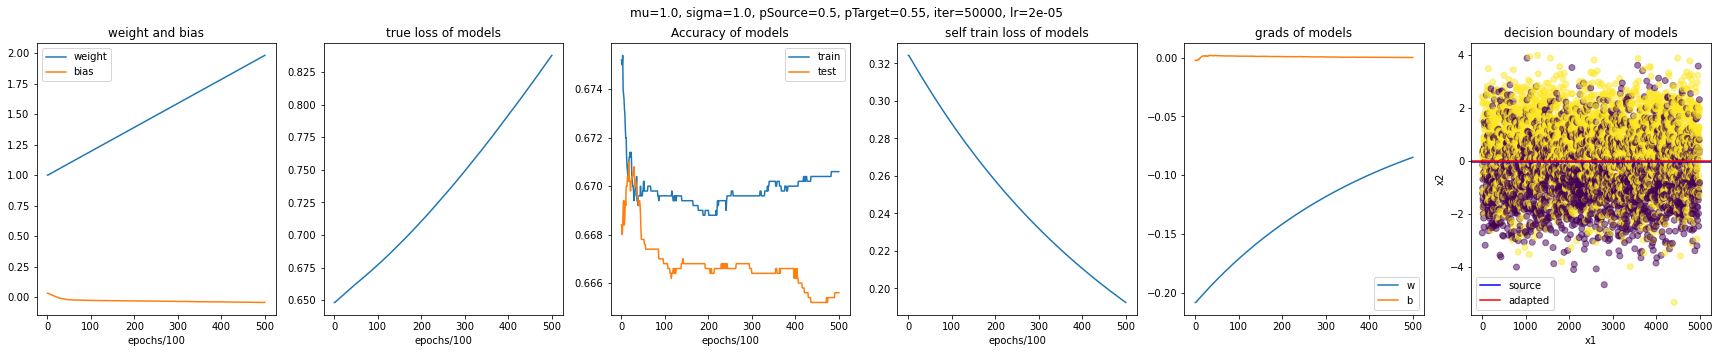

In [63]:
f, ax = plt.subplots(1, 6, figsize=(30, 5))
normsOfModels = [torch.norm(model[0][0].weight.data).item() for model in adaptedModels]
trueLossOfModels = [F.binary_cross_entropy_with_logits(model[0](xTargetTrain), yTargetTrain).detach() for model in adaptedModels]
trainAccuracyOfModels = [evaluate(model, xTargetTrain, yTargetTrain) for model in adaptedModels]
testAccuracyOfModels = [evaluate(model, xTargetTest, yTargetTest) for model in adaptedModels]
gradsW1Pos = []
gradsW1Neg = []
gradsW2Pos = []
gradsW2Neg = []
gradsB1Pos = []
gradsB1Neg = []
for model in adaptedModels:
    gradW1Pos, gradB1Pos = grad_by_data_on_model(model[0], xTargetTrain[yTargetTrain[:,0] == 1])
    gradW1Neg, gradB1Neg = grad_by_data_on_model(model[0], xTargetTrain[yTargetTrain[:,0] == 0])
    gradsW1Pos.append(gradW1Pos[0,0].item())
    gradsW1Neg.append(gradW1Neg[0,0].item())
    gradsB1Pos.append(gradB1Pos.item())
    gradsB1Neg.append(gradB1Neg.item())
    

selfTrainLossOfModels = []
for model in adaptedModels:
    probPred = torch.sigmoid(model[0](xTargetTrain))
    labelPred = (probPred > 0.5).float()
    selfTrainLossOfModels.append(F.binary_cross_entropy(probPred, labelPred).detach())

ax[0].plot(normsOfModels, label = 'weight')
ax[0].plot([model[0][0].bias.data.item() for model in adaptedModels], label = 'bias')
ax[0].set_title('weight and bias')
ax[0].set_xlabel('epochs/100')
ax[0].legend()
ax[1].plot(trueLossOfModels)
ax[1].set_title('true loss of models')
ax[1].set_xlabel('epochs/100')
ax[2].plot(trainAccuracyOfModels)
ax[2].plot(testAccuracyOfModels)
ax[2].set_title('Accuracy of models')
ax[2].legend(['train', 'test'])
ax[2].set_xlabel('epochs/100')
ax[3].plot(selfTrainLossOfModels)
ax[3].set_title('self train loss of models')
ax[3].set_xlabel('epochs/100')
# ax[4].plot(gradsW1Pos, alpha=0.3)
# ax[4].plot(gradsW1Neg, alpha=0.3)
# ax[4].plot(gradsB1Pos, alpha=0.3)
# ax[4].plot(gradsB1Neg, alpha=0.3)
ax[4].plot((np.array(gradsW1Pos) + np.array(gradsW1Neg))/2, alpha=1)
ax[4].plot((np.array(gradsB1Pos) + np.array(gradsB1Neg))/2, alpha=1)
ax[4].set_title('grads of models')
ax[4].legend(['w', 'b'])
plot_decision_boundaryH(adaptedModels[0][0], 'source', ax[5], 'b')
plot_decision_boundaryH(adaptedModels[-1][0], 'adapted', ax[5], 'r')
plt.scatter(list(range(n)), xTargetTrain, c=yTargetTrain, alpha=0.5)
ax[5].set_xlabel('x1')
ax[5].set_ylabel('x2')
ax[5].set_title('decision boundary of models')
f.suptitle('mu={}, sigma={}, pSource={}, pTarget={}, iter={}, lr={}'.format(mu, sigma, pSource, pTarget, iterations, lr))
plt.legend()
plt.show()

In [54]:
adaptedModels

[(Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8769)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8769)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8719)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8653)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8604)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8571)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8539)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8506)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8458)),
 (Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  ),
  tensor(1.8441)),
 (Sequential(
    (0): Linear(in_feature

In [58]:
i = 0
adaptedModels[i][0][0].weight.data, adaptedModels[i][0][0].bias.data

(tensor([[1.]]), tensor(-0.0010))